<a href="https://colab.research.google.com/github/mahmad2005/Palette_Cohort_6/blob/main/AgriSKSolutions_Take_home_Interview_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Take-Home Interview Questions**

Please refer to the links below when answering the questions.

1. https://en.wikipedia.org/wiki/List_of_countries_by_vegetable_production
2. https://hub.arcgis.com/datasets/esri::world-countries-generalized/explore?location=-0.123916%2C0.000000%2C1.68
3. https://en.wikipedia.org/wiki/List_of_countries_by_population_(United_Nations)


Question 1:

Using the provided data sources, identify the countries with the highest vegetable production per capita. Include the production amount per capita in your findings.



Question 2:

Create a visualization that maps the total and per capita vegetable production across all countries. Ensure the map is clear and provides insights into geographic production trends.

#**Solution:**

First, I collected data from the provided sources. However, I noticed that the population data on Wikipedia was outdated. To ensure accuracy and reliability, I opted to use the latest population data from Worldometer, which is more recent and dependable.

The vegetable production dataset from Wikipedia includes data for 194 countries, which I used as the reference dataset. Country names in this dataset served as the basis for merging other datasets. During the merging process, any countries not present in the vegetable production dataset were excluded to maintain consistency and ensure accurate analysis.

Additionally, Taiwan and Hong Kong are not defined as independent entities in the provided shapefile map; instead, they are represented as part of China. Since these regions are less significant to the overall analysis, I chose to exclude them from the mapping process for simplicity and consistency.

In [1]:
# Mounting google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install fuzzywuzzy
!pip install python-Levenshtein

# Import Libraries Pandas, NumPy, Geopandas, Matplotlib, Seaborn, fuzzywuzzy
import pandas as pd
import numpy as np
import fuzzywuzzy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 42.3 MB/s eta 0:00:00


In [3]:
# Read datasets shared in Slack Channel
World_Population_2024=pd.read_csv('/content/drive/MyDrive/PalleteSkills/World_Population_2024.csv')
Vegetable_Production_byCountries=pd.read_csv('/content/drive/MyDrive/PalleteSkills/Countries_by_Vegetable_Production.csv')

In [4]:
# Copying from the main file
vegetable_data = Vegetable_Production_byCountries.copy()
population_data = World_Population_2024.copy()

# Ensure All Values Are Strings
vegetable_data['Country/Region'] = vegetable_data['Country/Region'].astype(str)
population_data['Country (or dependency)'] = population_data['Country (or dependency)'].astype(str)

# Handle Missing Values
vegetable_data['Country/Region'] = vegetable_data['Country/Region'].fillna("Unknown")
population_data['Country (or dependency)'] = population_data['Country (or dependency)'].fillna("Unknown")

# Replace 'nan' or similar string representations with actual np.nan
vegetable_data['Country/Region'] = vegetable_data['Country/Region'].replace(['nan', ''], np.nan)
population_data['Country (or dependency)'] = population_data['Country (or dependency)'].replace(['nan', ''], np.nan)

# Remove rows with null or missing country names in the vegetable dataset
vegetable_data_cleaned = vegetable_data.dropna(subset=['Country/Region'])

# Reset the index after cleaning
vegetable_data_cleaned.reset_index(drop=True, inplace=True)

In [5]:
# Custom mapping for known issues
custom_mapping = {
    "Ivory Coast": "Côte d'Ivoire",
    "Democratic Republic of the Congo" : "DR Congo"
    # Add more mappings for other known issues
}

**Note:**
There were discrepancies in naming conventions across the three datasets. To address this, I utilized FuzzyWuzzy, a fuzzy string matching technique, to standardize and align the country names, ensuring consistency for analysis.

Initially, FuzzyWuzzy was applied to align and merge the first two datasets (Vegetable and Population datasets), resulting in a combined dataset (veg_pop). After completing the first analysis, I applied FuzzyWuzzy again to align the country names between the veg_pop dataset and the Geo dataset. This ensured a common naming convention, enabling the seamless merging of the two datasets based on country names for further analysis.

In [7]:

#Apply Fuzzy Matching
from fuzzywuzzy import process

def match_country_with_threshold(name, list_of_countries, threshold=80):
    if name in custom_mapping:
        return custom_mapping[name]
    result = process.extractOne(name, list_of_countries)
    if result[1] >= threshold:  # Check if the score meets the threshold
        return result[0]
    return name  # Return the original name if no good match is found

# Create a new DataFrame with updated country names
vegetable_data_cleaned_updated = vegetable_data_cleaned.copy()

# Apply fuzzy matching with a threshold
vegetable_data_cleaned_updated['Country/Region'] = vegetable_data_cleaned['Country/Region'].apply(
    lambda x: match_country_with_threshold(x, population_data['Country (or dependency)'].unique())
)

# See Number of Unique Countries in the Dataset
len(vegetable_data_cleaned_updated['Country/Region'].unique())

194

In [8]:
# Extract unique country names
veg_countries = vegetable_data_cleaned_updated['Country/Region'].unique()
pop_countries = population_data['Country (or dependency)'].unique()

# Convert to sets for easier comparison
veg_countries_set = set(veg_countries)
pop_countries_set = set(pop_countries)

print("Number of countries in Vegetable Dataset:", len(veg_countries_set))

# Countries in both datasets
common_countries = veg_countries_set.intersection(pop_countries)
print("Common countries:", len(common_countries))

Number of countries in Vegetable Dataset: 194
Common countries: 194


In [9]:
# Countries in Vegetable dataset but not in Population dataset
veg_only_countries = veg_countries_set.difference(pop_countries_set)
print("Countries in Vegetable dataset but not in Population dataset:", len(veg_only_countries))

# Countries in Population dataset but not in Vegetable dataset
pop_only_countries = pop_countries_set.difference(veg_countries_set)
print("Countries in Population dataset but not in Vegetable dataset:", len(pop_only_countries))


# Get the list of country names from vegetable_data_cleaned_updated
veg_countries = vegetable_data_cleaned_updated['Country/Region'].unique()

# Filter population_data to keep only countries that are in veg_countries
filtered_population_data = population_data[population_data['Country (or dependency)'].isin(veg_countries)]

# Verify the result
print("Filtered Population Data Shape:", filtered_population_data.shape)

Countries in Vegetable dataset but not in Population dataset: 0
Countries in Population dataset but not in Vegetable dataset: 40
Filtered Population Data Shape: (194, 12)


In [10]:
# Merge the datasets on the 'Country/Region' and 'Country (or dependency)' columns
merged_veg_pop_data = pd.merge(
    vegetable_data_cleaned_updated,
    filtered_population_data,
    left_on='Country/Region',
    right_on='Country (or dependency)',
    how='inner'  # Use 'inner' join to include only common countries
)

# Verify the result
print("Merged Dataset Shape:", merged_veg_pop_data.shape)

# Display the merged dataset
# print(merged_veg_pop_data.head())

Merged Dataset Shape: (194, 15)


In [18]:
# Drop the duplicate country column ('Country (or dependency)')
merged_veg_pop_data_cleaned = merged_veg_pop_data.drop(columns=['Country (or dependency)'])
merged_data = merged_veg_pop_data_cleaned
merged_data

,Rank,Country/Region,Vegetable production\n(tonnes),#,Population\n(2024),Yearly\nChange,Net\nChange,Density\n(P/Km²),Land Area\n(Km²),Migrants\n(net),Fert.\nRate,Med.\nAge,Urban\nPop %,World\nShare
0,1,China,"594,049,398",2,"1,419,321,278",-0.23 %,"-3,263,655",151,"9,388,211","-318,992",1.0,40,66 %,17.39 %
1,2,India,"141,195,036",1,"1,450,935,791",0.89 %,"12,866,195",488,"2,973,190","-630,830",2.0,28,37 %,17.78 %
2,3,United States,"33,124,467",3,"345,426,571",0.57 %,"1,949,236",38,"9,147,420","1,286,132",1.6,38,82 %,4.23 %
3,4,Turkey,"25,960,714",18,"87,473,805",0.23 %,"203,304",114,"769,630","-275,952",1.6,33,76 %,1.07 %
4,5,Vietnam,"17,002,195",16,"100,987,686",0.63 %,"635,494",326,"310,070","-59,645",1.9,33,41 %,1.24 %
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,190,Antigua and Barbuda,847,199,"93,772",0.49 %,456,213,440,9,1.6,36,28 %,0.00 %
190,191,Saint Kitts & Nevis,687,208,"46,843",0.18 %,85,180,260,-7,1.5,36,39 %,0.00 %
191,192,Tuvalu,596,227,"9,646",-1.73 %,-170,322,30,-280,3.2,24,83 %,0.00 %
192,193,Nauru,465,224,"11,947",0.61 %,72,597,20,-121,3.3,20,95 %,0.00 %


In [19]:
countries_by_production = merged_data[['Country/Region','Vegetable production\n(tonnes)','Population\n(2024)','Land Area\n(Km²)']]

In [21]:
countries_by_production['Vegetable production\n(tonnes)'] = countries_by_production['Vegetable production\n(tonnes)'].str.replace(',', '').astype(float)
countries_by_production

<ipython-input-21-480febaff224>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Country/Region,Vegetable production\n(tonnes),Population\n(2024),Land Area\n(Km²)
0,China,594049398.0,"1,419,321,278","9,388,211"
1,India,141195036.0,"1,450,935,791","2,973,190"
2,United States,33124467.0,"345,426,571","9,147,420"
3,Turkey,25960714.0,"87,473,805","769,630"
4,Vietnam,17002195.0,"100,987,686","310,070"
...,...,...,...,...
189,Antigua and Barbuda,847.0,"93,772",440
190,Saint Kitts & Nevis,687.0,"46,843",260
191,Tuvalu,596.0,"9,646",30
192,Nauru,465.0,"11,947",20


In [22]:
# Style the DataFrame
styled_table = countries_by_production[0:10].style.set_table_attributes('style="width:100%; border-collapse:collapse;"') \
    .set_caption("Top 10 Countries by Vegetable Production Per Capita") \
    .background_gradient(subset=['Vegetable production\n(tonnes)'], cmap='Blues') \
    .highlight_max(subset=['Vegetable production\n(tonnes)'], color='darkblue') \
    .format({
        'Vegetable production\n(tonnes)': '{:,.0f}',
    })

# Display the styled table
styled_table

,Country/Region,Vegetable production (tonnes),Population (2024),Land Area (Km²)
0,China,"594,049,398","1,419,321,278","9,388,211"
1,India,"141,195,036","1,450,935,791","2,973,190"
2,United States,"33,124,467","345,426,571","9,147,420"
3,Turkey,"25,960,714","87,473,805","769,630"
4,Vietnam,"17,002,195","100,987,686","310,070"
5,Egypt,"16,135,024","116,538,258","995,450"
6,Nigeria,"15,706,483","232,679,478","910,770"
7,Mexico,"15,098,212","130,861,007","1,943,950"
8,Russia,"13,950,679","144,820,423","16,376,870"
9,Spain,"12,668,790","47,910,526","498,800"


#**Countries with Highest Vegetable Production per Capita**

**Note:**
Vegetable Production per Capita is calculated by the equation below:
$$
\text{Per Capita Vegetable Production (tons)} = \frac{\text{Total Vegetable Production (metric tons)}}{\text{Population}}
$$


In [29]:
# Convert population and vegetable production columns to numeric (removing commas)
merged_data['Population (2024)'] = merged_data['Population\n(2024)'].str.replace(',', '').astype(float)
merged_data['Vegetable production (tonnes)'] = merged_data['Vegetable production\n(tonnes)'].str.replace(',', '').astype(float)

# Calculate vegetable production per capita
merged_data['Vegetable Production Per Capita (tonnes)'] = merged_data['Vegetable production (tonnes)'] / merged_data['Population (2024)']

merged_data['Rank By Production Per Capita'] = merged_data['Vegetable Production Per Capita (tonnes)'].rank(
    method='dense', ascending=False
).astype(int)  # 'dense' ensures consecutive ranking

# Sort by vegetable production per capita
sorted_data = merged_data.sort_values(by='Vegetable Production Per Capita (tonnes)', ascending=False)

# Display the top countries
top_countries = sorted_data[['Rank By Production Per Capita','Country/Region', 'Vegetable production (tonnes)', 'Population (2024)', 'Vegetable Production Per Capita (tonnes)']].head(20)

### Vegetable Production Per Capita by Country is Presented in the Table Below

In [31]:
# Visualize on a Table
import pandas as pd

# Style the DataFrame
styled_table = top_countries.style.set_table_attributes('style="width:100%; border-collapse:collapse;"') \
    .set_caption("Top 20 Countries by Vegetable Production Per Capita") \
    .background_gradient(subset=['Vegetable Production Per Capita (tonnes)'], cmap='Blues') \
    .highlight_max(subset=['Vegetable Production Per Capita (tonnes)'], color='darkblue') \
    .format({
        'Vegetable production (tonnes)': '{:,.0f}',
        'Population (2024)': '{:,.0f}',
        'Vegetable Production Per Capita (tonnes)': '{:,.3f}',
        'Rank By Production Per Capita': '{:,.0f}'
    }) \
    .set_table_styles([
        {'selector': 'thead th',  # Target column headers
         'props': [('background-color', 'darkblue'),  # Set background color
                   ('color', 'white'),               # Set text color
                   ('font-size', '14px'),            # Set font size
                   ('text-align', 'center')]}        # Center align text
    ])

# Display the styled table
styled_table


,Rank By Production Per Capita,Country/Region,Vegetable production (tonnes),Population (2024),Vegetable Production Per Capita (tonnes)
0,1,China,"594,049,398","1,419,321,278",0.419
82,2,North Macedonia,"695,920","1,823,009",0.382
72,3,Albania,"988,507","2,791,765",0.354
3,4,Turkey,"25,960,714","87,473,805",0.297
22,5,Netherlands,"5,293,140","18,228,742",0.290
14,6,Uzbekistan,"9,903,740","36,361,859",0.272
9,7,Spain,"12,668,790","47,910,526",0.264
158,8,Tonga,"27,320","104,175",0.262
35,9,Tunisia,"3,138,362","12,277,109",0.256
15,10,Ukraine,"9,675,389","37,860,221",0.256


### Vegetable Production Per Capita by Country is Displayed in the Bar Chart Below

In [36]:
import plotly.express as px

# Create a bar chart with Plotly
fig = px.bar(
    top_countries[0:15],
    x="Country/Region",  # X-axis: Countries
    y="Vegetable Production Per Capita (tonnes)",  # Y-axis: Vegetable Production Per Capita (tonnes)
    text="Vegetable Production Per Capita (tonnes)",  # Display production per capita as text on bars
    hover_data={
        "Vegetable production (tonnes)": ":,.0f",  # Show total production with commas
        "Population (2024)": ":,.0f",  # Show population with commas
        "Vegetable Production Per Capita (tonnes)": ":,.3f",  # Show per capita production
    },
    title="Top 15 Countries in Vegetable Production Per Capita (Tonnes)",
    labels={
        "Country/Region": "Country",
        "Vegetable Production Per Capita (tonnes)": "Per Capita Production (Tonnes)",
    },
)

# Customize the layout
fig.update_traces(textposition="outside")  # Show text outside the bars
fig.update_layout(
    xaxis_title="Country",
    yaxis_title="Vegetable Production Per Capita (Tonnes)",
    hoverlabel=dict(font_size=18),  # Adjust hover label font size
    #height=500,  # Set figure height
    #width=800,  # Set figure width
)

# Show the figure
fig.show()


### Vegetable Production Per Capita by Country is Displayed in the Pie Chart Below

In [35]:
import plotly.express as px

# Create a pie chart with Plotly
fig = px.pie(
    top_countries[0:15],
    values="Vegetable Production Per Capita (tonnes)",  # Values for the pie slices
    names="Country/Region",  # Labels for the pie slices (countries)
    title="Top 15 Countries in Vegetable Production Per Capita (Tonnes)",
    hover_data={
        "Vegetable production (tonnes)": ":,.0f",  # Show total production with commas
        "Population (2024)": ":,.0f",  # Show population with commas
        "Vegetable Production Per Capita (tonnes)": ":,.2f",  # Show per capita production
    },
    labels={
        "Country/Region": "Country",
        "Vegetable Production Per Capita (tonnes)": "Per Capita Production (Tonnes)",
    },
)

# Customize the layout
fig.update_traces(
    textinfo="percent+label",  # Show percentage and country name inside the slices
    #textinfo ="none",
    hovertemplate=(
        "<b>%{label}</b><br>"  # Show country name
        "Vegetable Production Per Capita: %{value:.2f} tonnes<br>"  # Show per capita production
        "Total Production: %{customdata[0]:,.0f} tonnes<br>"  # Show total production
        "Population: %{customdata[1]:,.0f}"  # Show population
    ),
)

# Show the figure
fig.show()


### Top 15 Countries in Vegetable Production are Displayed Below in the Bar Chart

In [38]:
import plotly.express as px

top_countries_by_production = merged_data.sort_values(by='Vegetable production (tonnes)', ascending=False)
top_countries_by_production["Land Area (Km²)"] = top_countries_by_production["Land Area\n(Km²)"].str.replace(',', '').astype(float)

# Calculate Vegetable Production per Km²
top_countries_by_production["Vegetable Production per Km²"] = (
    top_countries_by_production["Vegetable production (tonnes)"] / (top_countries_by_production["Land Area (Km²)"])
)

# Create a bar chart
fig_bar = px.bar(
    top_countries_by_production[0:15],
    x="Country/Region",  # X-axis: Countries
    y="Vegetable production (tonnes)",  # Y-axis: Vegetable Production
    text="Vegetable production\n(tonnes)",  # Display production as text on bars
    hover_data={
        "Vegetable production (tonnes)": ":,.0f",  # Total production
        "Population (2024)": ":,.0f",  # Population
        "Vegetable Production Per Capita (tonnes)": ":,.2f",  # Per capita production
        "Land Area (Km²)": ":,.0f",  # Land area
        "Vegetable Production per Km²": ":,.2f",  # Production per Km²
    },
    title="Top 15 Countries by Vegetable Production",
    labels={
        "Country/Region": "Country",
        "Vegetable production (tonnes)": "Total Vegetable Production (Tonnes)",
    },
)

# Customize the layout
fig_bar.update_traces(textposition="outside")  # Show text outside the bars
fig_bar.update_layout(
    xaxis_title="Country",
    yaxis_title="Vegetable Production (Tonnes)",
    hoverlabel=dict(font_size=12),  # Adjust hover label font size
    #height=500,  # Set figure height
    #width=800,  # Set figure width
)

# Show the bar chart
fig_bar.show()


### Global Distribution of Vegetable Production displayed on a Pie Chart

In [40]:
import plotly.express as px

# Fill missing values
top_countries_by_production["Population (2024)"] = top_countries_by_production["Population (2024)"].fillna(0)
top_countries_by_production["Vegetable Production Per Capita (tonnes)"] = top_countries_by_production["Vegetable Production Per Capita (tonnes)"].fillna(0)
top_countries_by_production["Land Area (Km²)"] = top_countries_by_production["Land Area (Km²)"].fillna(0)
top_countries_by_production["Vegetable Production per Km²"] = top_countries_by_production["Vegetable Production per Km²"].fillna(0)


# Create a pie chart for countries by vegetable production
fig_pie = px.pie(
    top_countries_by_production,
    values="Vegetable production (tonnes)",  # Values for the pie slices
    names="Country/Region",  # Labels for the pie slices
    title="Global Distribution of Vegetable Production",
    hover_data={
        "Vegetable production (tonnes)": ":,.0f",  # Total production
        "Population (2024)": ":,.0f",  # Population
        "Vegetable Production Per Capita (tonnes)": ":,.2f",  # Per capita production
        "Land Area (Km²)": ":,.0f",  # Land area
        "Vegetable Production per Km²": ":,.2f",  # Production per Km²
    },
    labels={
        "Country/Region": "Country",
        "Vegetable production (tonnes)": "Total Vegetable Production (Tonnes)",
    },
)

# Customize the layout
fig_pie.update_traces(
    textinfo="none",  # Remove percentage and country name text from slices
    hovertemplate=(
        "<b>%{label}</b><br>"  # Country name
        "Vegetable Production: %{value:,.0f} tonnes<br>"  # Total production
        "Population: %{customdata[0][1]:,.0f}<br>"  # Population
        "Vegetable Production Per Capita: %{customdata[0][2]:,.2f} tonnes<br>"  # Per capita production
        "Land Area: %{customdata[0][3]:,.0f} Km²<br>"  # Land area
        "Vegetable Production per Km²: %{customdata[0][4]:,.2f} tonnes/Km²"  # Production per Km²
    ),
)

fig_pie.update_layout(
    hoverlabel=dict(font_size=15),  # Adjust hover label font size
    #height=500,  # Set figure height
    #width=800,  # Set figure width
)

# Show the pie chart
fig_pie.show()



#**Integration of GeoData with Vegetable and Population Data**

In [144]:
import geopandas as gpd
import pandas as pd
import plotly.express as px

# Load geospatial data (GeoJSON or shapefile)
geo_data = gpd.read_file('/content/drive/MyDrive/PalleteSkills/World_Countries_(Generalized)_9029012925078512962.geojson')

# null fillup
geo_data['COUNTRY'] = geo_data['COUNTRY'].astype(str).fillna("Unknown").replace(['nan', ''], np.nan)

In [145]:
# Custom mapping for known issues
custom_mapping = {
    "Ivory Coast": "Côte d'Ivoire",
    "Democratic Republic of the Congo" : "DR Congo",
    "Turkiye" : "Turkey",
    "Congo DRC" : "DR Congo"
    # Add more mappings for other known issues
}

In [146]:
from fuzzywuzzy import process

def match_country_with_threshold(name, list_of_countries, threshold=80):
    if name in custom_mapping:
        return custom_mapping[name]
    result = process.extractOne(name, list_of_countries)
    if result[1] >= threshold:  # Check if the score meets the threshold
        return result[0]
    return name  # Return the original name if no good match is found

# Get the list of unique country names in geo_data
geo_countries = geo_data['COUNTRY'].unique()

# Update the country names in geo_data to match those in vegetable_data_cleaned
# Extract updated names from vegetable_data_cleaned
updated_countries = merged_data['Country/Region'].unique()

# Match and update country names in geo_data
geo_data['COUNTRY'] = geo_data['COUNTRY'].apply(
    lambda x: match_country_with_threshold(x, updated_countries)
)

In [147]:
# Extract unique country names
merged_countries = merged_data['Country/Region'].unique()
geo_countries = geo_data['COUNTRY'].unique()

# Convert to sets for easier comparison
merged_countries_set = set(merged_countries)
geo_countries_set = set(geo_countries)

print("Number of countries in Veg-pop merged Dataset:", len(merged_countries_set))

# Countries in both datasets
common_countries = geo_countries_set.intersection(merged_countries)
print("Number of countries in both Veg-pop and GeoData Dataset:", len(common_countries))



# Find countries in the merged dataset that are NOT in the geo dataset
countries_not_in_geo = merged_countries_set - geo_countries_set

# Display results
print("Number of countries in the merged dataset:", len(merged_countries_set))
print("Number of common countries:", len(geo_countries_set.intersection(merged_countries_set)))
print("Countries in the veg-pop merged dataset that are NOT in the geo dataset:")
print(countries_not_in_geo)



Number of countries in Veg-pop merged Dataset: 194
Number of countries in both Veg-pop and GeoData Dataset: 192
Number of countries in the merged dataset: 194
Number of common countries: 192
Countries in the veg-pop merged dataset that are NOT in the geo dataset:
{'Taiwan', 'Hong Kong'}


In [148]:
# Load your vegetable production dataset
data = merged_data.copy()

# Clean data: Ensure production and population data are numeric
data['Vegetable production (tonnes)'] = data['Vegetable production\n(tonnes)'].str.replace(',', '').astype(float)
data['Population (2024)'] = data['Population\n(2024)'].str.replace(',', '').astype(float)
data['Land Area (Km²)'] = data['Land Area\n(Km²)'].str.replace(',', '').astype(float)

# Calculate Vegetable Production per Km²
data["Vegetable Production per Km²"] = (
    data["Vegetable production (tonnes)"] / (data["Land Area (Km²)"])
)

# Calculate production per capita
#data['Vegetable Production Per Capita (tonnes)'] = data['Vegetable production (tonnes)'] / data['Population (2024)']

# Merge GeoJSON data with vegetable production data
geo_data = geo_data.merge(data, left_on="COUNTRY", right_on="Country/Region", how="left")

# Fill missing values for countries without production data
geo_data['Vegetable production (tonnes)'] = geo_data['Vegetable production (tonnes)'].fillna(0)
geo_data['Vegetable Production Per Capita (tonnes)'] = geo_data['Vegetable Production Per Capita (tonnes)'].fillna(0)
geo_data['Rank By Production Per Capita'] = geo_data['Rank By Production Per Capita'].fillna(0).astype(int)  # Convert to integer


<Axes: >

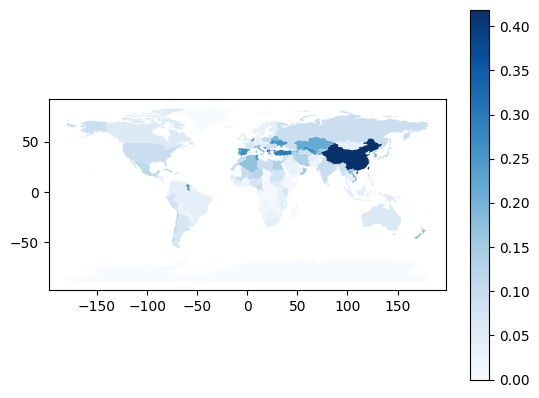

In [149]:
geo_data.plot(column='Vegetable Production Per Capita (tonnes)', cmap='Blues', legend=True)

#**Visualization on the Map**

In [ ]:
import geopandas as gpd
import folium

# Initialize a folium map
m = folium.Map(location=[20, 0], zoom_start=2) # , tiles=None

# Add layer for "Vegetable Production (Tonnes)"
choropleth_total_production = folium.Choropleth(
    geo_data=geo_data.to_json(),
    data=geo_data,
    columns=["COUNTRY", "Vegetable production (tonnes)"],
    key_on="feature.properties.COUNTRY",
    fill_color="Greens",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Vegetable Production (Tonnes)",
    name="Total Vegetable Production",
    show=False,  # Start with this layer selected
).add_to(m)

# Add tooltips for "Vegetable Production (Tonnes)"
for _, row in geo_data.iterrows():
    country_name = row['ISO'].lower()
    flag_url = f"https://flagcdn.com/w320/{country_name}.png"
    tooltip_html = f"""
        <div style="font-size:14px; font-weight:bold; padding:10px; background-color:rgba(255, 255, 255, 0.9); border:1px solid black; border-radius:5px;">
            <center>Vegetable Production</center><br>
            <img src="{flag_url}" alt="Flag" style="width:50px; height:auto;"><br>
            <b>Rank:</b> {row['Rank']}<br>
            <b>Country:</b> {row['COUNTRY']}<br>
            <span style="border-bottom: 2px solid red; padding: 2px;"><b>Total Production: </b><b>{row['Vegetable production (tonnes)']:,.0f} tonnes</b></span><br>
            <b>Total Population:</b> {row['Population (2024)']:,.0f} people<br>
            <b>Per Capita Production:</b> <span style="background-color:#98FF98; padding:2px; border-radius:3px;"><b>{row['Vegetable Production Per Capita (tonnes)']:.3f}</b></span> tonnes<br>
            <b>Land Area:</b> {row['Land Area (Km²)']:,.0f} Km²<br>
            <b>Vegetable Production per Km²:</b> {row['Vegetable Production per Km²']:.3f} tonnes/Km²
        </div>
    """
    folium.GeoJson(
        row["geometry"],
        tooltip=folium.Tooltip(tooltip_html),
        style_function=lambda x: {"fillColor": "transparent", "color": "black", "weight": 0},
    ).add_to(choropleth_total_production)

# Add layer for "Vegetable Production Per Capita (Tonnes)"
choropleth_per_capita_production = folium.Choropleth(
    geo_data=geo_data.to_json(),
    data=geo_data,
    columns=["COUNTRY", "Vegetable Production Per Capita (tonnes)"],
    key_on="feature.properties.COUNTRY",
    fill_color="Blues",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Vegetable Production Per Capita (Tonnes)",
    name="Veg. Production Per Capita",
    show=True,  # Do not start with this layer selected
).add_to(m)

# Add tooltips for "Vegetable Production Per Capita (Tonnes)"
for _, row in geo_data.iterrows():
    country_name = row['ISO'].lower()
    flag_url = f"https://flagcdn.com/w320/{country_name}.png"
    tooltip_html = f"""
        <div style="font-size:14px; font-weight:bold; padding:10px; background-color:rgba(255, 255, 255, 0.9); border:1px solid black; border-radius:5px;">
            <center>Vegetable Production</center><br>
            <img src="{flag_url}" alt="Flag" style="width:50px; height:auto;"><br>
            <b>Rank:</b> {row['Rank By Production Per Capita']}<br>
            <b>Country:</b> {row['COUNTRY']}<br>
            <b>Per Capita Production:</b> <span style="background-color:#98FF98; padding:2px; border-radius:3px;"><b>{row['Vegetable Production Per Capita (tonnes)']:.3f}</b></span> tonnes<br>
            <b>Total Production :</b><span style="border-bottom: 2px solid red; padding: 2px;"><b>{row['Vegetable production (tonnes)']:,.0f}</b></span> tonnes<br>
            <b>Total Population:</b> {row['Population (2024)']:,.0f} people<br>
            <b>Land Area:</b> {row['Land Area (Km²)']:,.0f} Km²<br>
            <b>Vegetable Production per Km²:</b> {row['Vegetable Production per Km²']:.3f} tonnes/Km²
        </div>
    """
    folium.GeoJson(
        row["geometry"],
        tooltip=folium.Tooltip(tooltip_html),
        style_function=lambda x: {"fillColor": "transparent", "color": "black", "weight": 0},
    ).add_to(choropleth_per_capita_production)


# Add a custom tile layer with a new name
#folium.TileLayer(
#    tiles='https://www.openstreetmap.org/copyright',
#    name='Select Option',  # Change the name here
#    attr='OpenStreetMap'
#).add_to(m)


# Add layer control to toggle between layers
folium.LayerControl(collapsed=False).add_to(m)

# Save the map to an HTML file
m.save("interactive_vegetable_production_map_with_flags.html")

# Display the map in the notebook (optional)
m

In [ ]:

geo_data = geo_data.iloc[0:0].drop(columns=geo_data.columns)
geo_data = gpd.GeoDataFrame()
merged_data

In [143]:
geo_data.columns

RangeIndex(start=0, stop=0, step=1)